In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from queue import Queue
import sys
from dataclasses import dataclass

## Utils functions

In [4]:
def draw_with_colors(graph, highlight_nodes = [], even_more_nodes = []):
    node_colors = ['red' if node in highlight_nodes else 'green' if node in even_more_nodes else 'blue' for node in graph.nodes()]
    nx.draw(graph, with_labels=True, font_weight='bold', node_color=node_colors)
    plt.show()

def print_graph_representation(g):
    print("{")
    for node in g.nodes():
        neighbors = list(g.neighbors(node))
        print(f"{node}: {neighbors},")
    print("}")
    
def dict_to_nx_graph(graph_dict):
    return nx.from_dict_of_lists(graph_dict, create_using=nx.DiGraph)

def get_random_graph_with_starting_vertices(n=3, p=0.3, n_starting_vertices=2, n_final_vertices=2, seed=None):
    g = nx.gnp_random_graph(n, p, directed=True, seed=seed)
    nodes = list(g.nodes())
    starting_vertices = nodes[:n_starting_vertices].copy()
    final_vertices = nodes[n_starting_vertices:(n_starting_vertices + n_final_vertices)].copy()
    return g, starting_vertices, final_vertices

## Algorithm 

### BFS part of the algorithm

In [5]:
def unoptimized_build_parent_graph(graph, starting_nodes, _final_vertices):
    visited = {s_i: [] for s_i in starting_nodes}
    open = Queue()
    for s in starting_nodes:
        open.put(s)

    while not open.empty():
        current_node = open.get()
        for n in graph.neighbors(current_node):
            if n not in visited:
                visited[n] = [current_node]
                open.put(n)
            else:
                parents = visited[n].copy()
                parents.append(current_node)
                visited[n] = parents
    return visited


def optimized_build_parent_graph(graph, starting_nodes, _final_vertices):
    visited = {s_i: (set(), {s_i}) for s_i in starting_nodes}
    open = Queue()
    for s in starting_nodes:
        open.put(s)

    while not open.empty():
        current_node = open.get()
        parents_curr, starting_vertices_curr = visited[current_node]
        for n in graph.neighbors(current_node):
            if n not in visited:
                visited[n] = ({current_node}, starting_vertices_curr.copy())
                open.put(n)
            else:
                parents_n, starting_vertices_n = visited[n]
                dif = starting_vertices_curr - starting_vertices_n
                if len(dif) > 0:
                    visited[n] = (parents_n | {current_node}) - {n} , starting_vertices_n | starting_vertices_curr
                    p, _ = visited[n]
                    if n in p:
                        print(f"Curr = {current_node}")
                        print(f"n = {n}")
                        print(visited)
                        print(open)
    transformed_visited = {n: parents for n, (parents, _) in visited.items()}
    return transformed_visited


### Extracting paths

In [6]:
def _extract_path_helper(node, curr_path, parent_graph, processed, starting_vertices):
    if node in starting_vertices:
        return {node: [node]}
    ret = {}
    curr_path.add(node)
    for parent in parent_graph.neighbors(node):
        reachable_from_parent = set()
        if parent in processed:
            reachable_from_parent = processed[parent]
        elif parent not in curr_path:
            reachable_from_parent = _extract_path_helper(parent, curr_path.copy(), parent_graph, processed, starting_vertices)
        for starting_node, path in reachable_from_parent.items():
            path_with_current_node = path.copy()
            path_with_current_node.append(node)
            ret[starting_node] = path_with_current_node
    processed[node] = ret
    return ret
        
def extract_path(parent_graph, starting_vertices, final_vertices):
    processed = dict()
    for f in final_vertices:
        _extract_path_helper(f, set(), parent_graph, processed, starting_vertices)
    return processed

### Full flow

In [7]:
def find_paths(graph, starting_vertices, final_vertices):
    parent_graph_dict = optimized_build_parent_graph(graph, starting_vertices, final_vertices)
    parent_graph = dict_to_nx_graph(parent_graph_dict)
    ret = extract_path(parent_graph, starting_vertices, final_vertices)
    return ret

## Simulation

In [8]:

def handle_graph_unoptimized(graph, starting_nodes, final_vertices):
    bfs_g = unoptimized_build_parent_graph(graph, starting_nodes, final_vertices)
    nx_bfs_g = dict_to_nx_graph(bfs_g)
    cycles = list(nx.simple_cycles(nx_bfs_g))
    if len(cycles) > 0:
        print("########## cycles detected #####################")
        print("original graph")
        draw_with_colors(graph, starting_nodes)
        print("bfs graph")
        draw_with_colors(nx_bfs_g, starting_nodes)
        for cycle in cycles:
            print(cycle)
        return False
    else:
        return True

def handle_graph_optimized(graph, starting_nodes, final_vertices):
    bfs_g = optimized_build_parent_graph(graph, starting_nodes, final_vertices)
    nx_bfs_g = dict_to_nx_graph(bfs_g)
    cycles = list(nx.simple_cycles(nx_bfs_g))
    if len(cycles) > 0:
        print("########## cycles detected #####################")
        print("original graph")
        print_graph_representation(graph)
        draw_with_colors(graph, starting_nodes)
        print("bfs graph")
        print_graph_representation(nx_bfs_g)
        draw_with_colors(nx_bfs_g, starting_nodes)
        for cycle in cycles:
            print(cycle)
        return False
    else:
        return True
        


def simulate(n_simulations=100, initial_seed=45):
    seed = initial_seed
    for i in range(n_simulations):
        g, starting, final = get_random_graph_with_starting_vertices(seed=seed)
        if not handle_graph_optimized(g, starting, final):
            print("Simulation end")
            return
        print("#################################")
        seed += 1
    print("Simulation end")

########## cycles detected #####################
original graph
{
0: [1],
1: [0],
2: [0, 1],
}


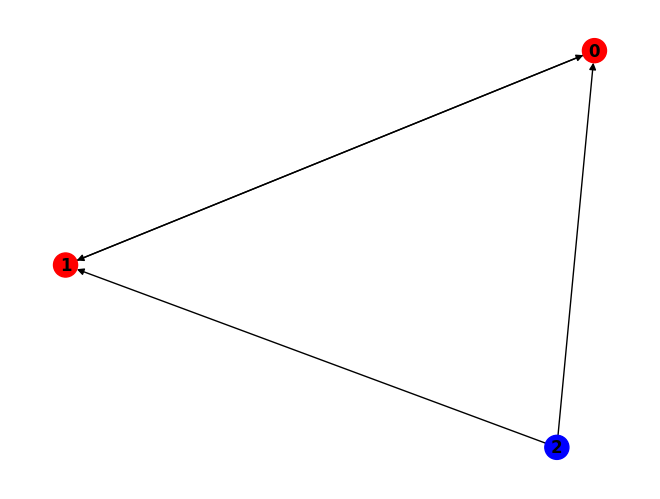

bfs graph
{
0: [1],
1: [0],
}


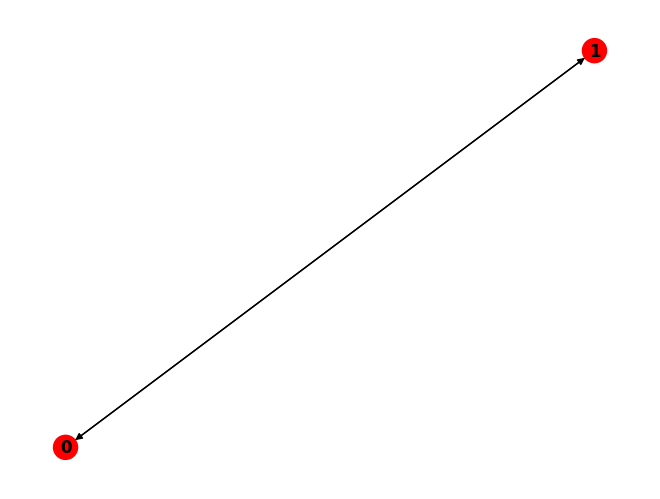

[0, 1]
Simulation end


In [9]:
simulate()

## Examples


In [10]:
@dataclass
class Example:
    graph: nx.Graph
    starting_vertices: [int]
    final_vertices: [int]

def create_example(graph_dict, sv, fv):
    return Example(dict_to_nx_graph(graph_dict), sv, fv)

In [11]:
def handle_example(e):
    draw_with_colors(e.graph, e.starting_vertices)
    bfs_g = optimized_build_parent_graph(e.graph, e.starting_vertices, e.final_vertices)
    nx_bfs_g = dict_to_nx_graph(bfs_g)
    cycles = list(nx.simple_cycles(nx_bfs_g))
    print_graph_representation(nx_bfs_g)
    draw_with_colors(nx_bfs_g, e.starting_vertices)    
    if len(cycles) > 0:
        print("CYCLES DETECTED")
        for cycle in cycles:
            print(cycle)

def run_full_flow(e):
    print(e)
    draw_with_colors(e.graph, e.starting_vertices, e.final_vertices)
    paths = find_paths(e.graph, e.starting_vertices, e.final_vertices)
    print(paths)

### Custom examples

In [12]:
e_triangle = create_example({0: [2],
1: [0],
2: [1]}, [0, 1], [2])

In [13]:
def optimized_build_parent_graph(graph, starting_nodes, _final_vertices):
    visited = {s_i: (set(), {s_i}) for s_i in starting_nodes}
    open = Queue()
    for s in starting_nodes:
        open.put(s)
    while not open.empty():
        current_node = open.get()
        parents_curr, starting_vertices_curr = visited[current_node]
        for n in graph.neighbors(current_node):
            if n not in visited:
                visited[n] = ({current_node}, starting_vertices_curr.copy())
                open.put(n)
            else:
                parents_n, starting_vertices_n = visited[n]
                dif = starting_vertices_curr - starting_vertices_n
                if len(dif) > 0:
                    visited[n] = (parents_n | {current_node}) - {n} , starting_vertices_n | starting_vertices_curr
                    p, _ = visited[n]
                    if n in p:
                        print(f"Curr = {current_node}")
                        print(f"n = {n}")
                        print(visited)
                        print(open)
    transformed_visited = {n: parents for n, (parents, _) in visited.items()}
    return transformed_visited


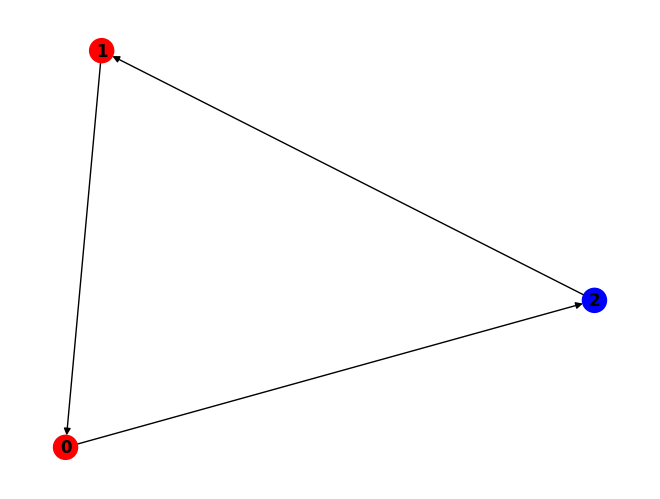

{
0: [1],
1: [2],
2: [0],
}


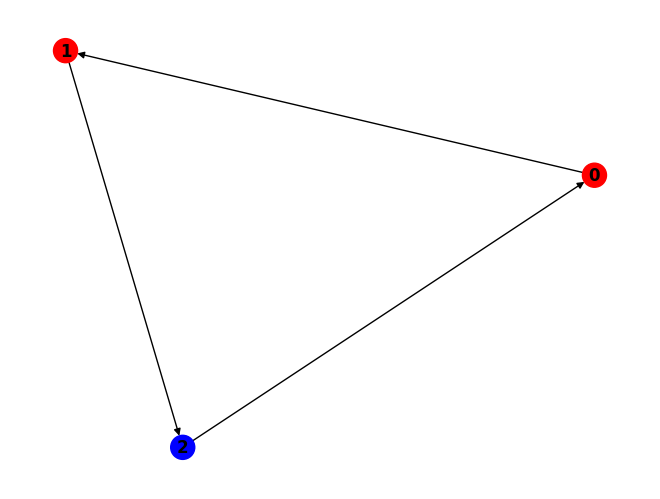

CYCLES DETECTED
[0, 1, 2]


In [14]:
handle_example(e_triangle) 

### Examples from the photo

In [17]:
e_1 = create_example({0: [2],
       1: [3],
       2: [4],
       3: [4],
       4: [5],
       5: [6]
}, [0, 1], [6])
e_2 = create_example({0: [2],
       1: [3],
       2: [4],
       3: [5],
       4: [6],
       5: [4, 7],
       6: [8],
       7: [9]
}, [0, 1], [8, 9])
e_3 = create_example({0: [2],
       1: [3],
       2: [4],
       3: [5],
       4: [6],
       5: [4, 8],
       6: [8],
}, [0, 1], [8])

Example(graph=<networkx.classes.digraph.DiGraph object at 0x7fbd12e1ab10>, starting_vertices=[0, 1], final_vertices=[8, 9])


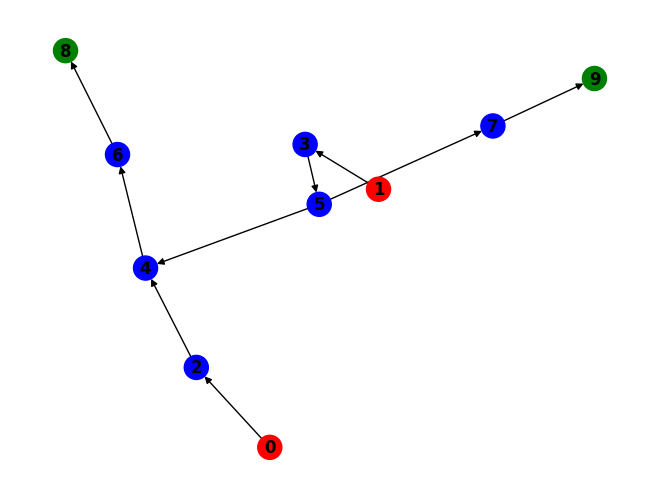

{2: {0: [0, 2]}, 3: {1: [1, 3]}, 5: {1: [1, 3, 5]}, 4: {0: [0, 2, 4], 1: [1, 3, 5, 4]}, 6: {0: [0, 2, 4, 6], 1: [1, 3, 5, 4, 6]}, 8: {0: [0, 2, 4, 6, 8], 1: [1, 3, 5, 4, 6, 8]}, 7: {1: [1, 3, 5, 7]}, 9: {1: [1, 3, 5, 7, 9]}}


In [19]:
run_full_flow(e_2)

In [ ]:
handle_example(e3)